In [8]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
!pip install keras-tuner
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.8 MB/s eta 0:00:00


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Insurance_claims_Final.csv')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cleaning data for model

In [4]:
# Mean for nan values in LossHour and PolicyHolderAge columns
df[['LossHour', 'PolicyHolderAge' , 'FpVehicleAgeMonths']] = df[['LossHour', 'PolicyHolderAge' , 'FpVehicleAgeMonths']].fillna(df[['LossHour', 'PolicyHolderAge' , 'FpVehicleAgeMonths']].mean())

# Dropping columns
df = df.drop(['ThirdPartyVehicleNumber', 'InsurerNotes', 'DamageImportance' , 'ConnectionBetweenParties'], axis=1)

# Filling low nan values column with mode
df['FirstPartyVehicleType'].fillna(df['FirstPartyVehicleType'].mode()[0], inplace=True)

df['LossDate'] = pd.to_datetime(df['LossDate'], infer_datetime_format=True)
df['LossDate'] = df['LossDate'].dt.strftime('%d-%m-%Y')
df['FirstPolicySubscriptionDate'] = pd.to_datetime(df['FirstPolicySubscriptionDate'], infer_datetime_format=True)
df['FirstPolicySubscriptionDate'] = df['FirstPolicySubscriptionDate'].dt.strftime('%d-%m-%Y')

constant = 1
df['claim_amount_log'] = np.log(df['ClaimAmount'] + constant)



In [5]:
df = df.drop(['ClaimAmount'] , axis=1)
cat_df = df.select_dtypes(include = ['object']).copy()

df.PolicyholderOccupation = pd.Categorical(df.PolicyholderOccupation).codes
df.ClaimCause = pd.Categorical(df.ClaimCause).codes
df.ClaimInvolvedCovers = pd.Categorical(df.ClaimInvolvedCovers).codes
df.FirstPartyVehicleType = pd.Categorical(df.FirstPartyVehicleType).codes
df.PolicyHolderPostCode = pd.Categorical(df.PolicyHolderPostCode).codes

#There were string values in the code which is changed to nan values
for i in range(len(df)):
    if isinstance(df.loc[i, 'LossPostCode'], str) and not df.loc[i, 'LossPostCode'].isnumeric():
        df.loc[i, 'LossPostCode'] = np.nan
    else:
        df.loc[i, 'LossPostCode'] = float(df.loc[i, 'LossPostCode'])

#Nan values are changed to 0
df[['LossPostCode']] = df[['LossPostCode']].fillna(0)

df = df.drop(['LossDate' , 'FirstPolicySubscriptionDate'] , axis=1)

df[['FirstPartyVehicleNumber', 'LossPostCode']] = df[['FirstPartyVehicleNumber', 'LossPostCode']].fillna(0)



In [6]:
X1 = df.drop('Fraud', axis=1)  # drop the target variable
y1 = df['Fraud']

Splitting data and creating model

In [9]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.15, random_state=172)
X1_train, X1_valid, y1_train, y1_valid = train_test_split(X1_train, y1_train, test_size=0.8, random_state=172)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation="relu", kernel_initializer='uniform'),
    tf.keras.layers.Dense(32, activation="relu", kernel_initializer='uniform'),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_initializer='uniform')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
log_1 = model.fit(X1_train, y1_train, epochs=100, batch_size=256, validation_data=(X1_valid, y1_valid))

def train_model(hp):    
    num_units = hp.Int('num_units', min_value = 32, max_value=256) 
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value=0.3) 
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=0.1, sampling='log') 
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])
    
    return model





Epoch 1/100
8/8 [==============================] - 5s 124ms/step - loss: 8.6269 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.7164 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 0s 55ms/step - loss: 6.6701 - precision: 0.0093 - recall: 0.0909 - val_loss: 3.7961 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 0s 61ms/step - loss: 6.2085 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 6.6014 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 8.6206 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 6.9235 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
8/8 [==============================] - 0s 41ms/step - loss: 8.4638 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 6.1966 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/100
8/8 [==========

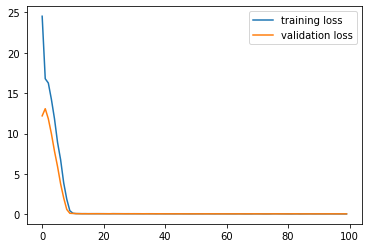

In [ ]:
plt.plot(log_1.history['loss'],label = "training loss")
plt.plot(log_1.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

Prediction

In [10]:
y_pred = model.predict(X1_test)

55/55 [==============================] - 0s 2ms/step


In [11]:
conf_matrix = tf.math.confusion_matrix(y1_test, y_pred)
tn, fp, fn, tp = conf_matrix.numpy().ravel()
hit_rate = tp / (tp + fn)
decision_rate = (tp + fp) / (tp + tn + fp + fn)
print("Hit rate:", hit_rate)
print("Decision rate:", decision_rate)

Hit rate: 0.0
Decision rate: 0.0


Hyper parameter tuning to find best best parameters

In [12]:
tuner = kt.Hyperband(train_model,
                     objective='val_loss',
                     max_epochs=5,
                     factor=3,
                     directory='logs',
                     project_name='kt_tutorial_2')

tuner.search(X1_train, y1_train, validation_data=(X1_valid, y1_valid))

best_hps = tuner.get_best_hyperparameters()[0]
print("Best number of hidden units:", best_hps['num_units'])
print("Best dropout rate:", best_hps['dropout_rate'])
print("Best learning rate:", best_hps['learning_rate'])

Trial 10 Complete [00h 00m 07s]
val_loss: 43.12047576904297

Best val_loss So Far: 0.05161834880709648
Total elapsed time: 00h 01m 05s
Best number of hidden units: 69
Best dropout rate: 0.2916418759634546
Best learning rate: 0.07075066125528888


Prediction

In [16]:
best_model = tuner.hypermodel.build(best_hps)
best_model

In [22]:
y_pred_1 = best_model.predict(X1_test)

55/55 [==============================] - 0s 6ms/step


In [15]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

Training best model

In [19]:
M1=best_model.fit(X1_train, y1_train,
               epochs=30,
               validation_data=(X1_valid,y1_valid),
               callbacks=[early_stopping_cb])

Epoch 1/30
62/62 [==============================] - 7s 73ms/step - loss: 13453.6279 - binary_accuracy: 0.9597 - auc_2: 0.4860 - val_loss: 1.1144 - val_binary_accuracy: 0.9884 - val_auc_2: 0.5024
Epoch 2/30
62/62 [==============================] - 1s 18ms/step - loss: 184.1464 - binary_accuracy: 0.9816 - auc_2: 0.5082 - val_loss: 0.0530 - val_binary_accuracy: 0.9909 - val_auc_2: 0.5000
Epoch 3/30
62/62 [==============================] - 1s 15ms/step - loss: 37.8725 - binary_accuracy: 0.9867 - auc_2: 0.4130 - val_loss: 0.0520 - val_binary_accuracy: 0.9909 - val_auc_2: 0.5000
Epoch 4/30
62/62 [==============================] - 1s 19ms/step - loss: 12.0788 - binary_accuracy: 0.9867 - auc_2: 0.4969 - val_loss: 0.0517 - val_binary_accuracy: 0.9909 - val_auc_2: 0.5000
Epoch 5/30
62/62 [==============================] - 1s 11ms/step - loss: 0.0621 - binary_accuracy: 0.9888 - auc_2: 0.5535 - val_loss: 0.0525 - val_binary_accuracy: 0.9909 - val_auc_2: 0.5000
Epoch 6/30
62/62 [===================

In [20]:
best_model.evaluate(X1_test, y1_test)

55/55 [==============================] - 0s 3ms/step - loss: 0.0691 - binary_accuracy: 0.9873 - auc_2: 0.5000


[0.0690934807062149, 0.9872832298278809, 0.5]

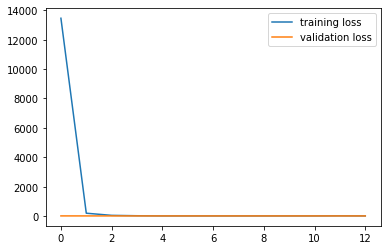

In [21]:
plt.plot(M1.history['loss'], label='training loss')
plt.plot(M1.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [23]:
conf_matrix = tf.math.confusion_matrix(y1_test, y_pred_1)
tn, fp, fn, tp = conf_matrix.numpy().ravel()
hit_rate = tp / (tp + fn)
decision_rate = (tp + fp) / (tp + tn + fp + fn)
print("Hit rate:", hit_rate)
print("Decision rate:", decision_rate)

Hit rate: 0.0
Decision rate: 0.0
